In [68]:
import test_visualization as tv

In [107]:
import tensorflow as tf
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
tf.__version__
path = "../../"
model_path = path + "models/"
test_path = path + "data/test/"
model_path_cull = model_path + "cull%i/" % 1
sys.path.insert(0, model_path + "model_functions")
sys.path.insert(0, path + "preprocess")

import primary_model as pm
import fasta_to_1_hot_encodings as fthe
import get_contact_maps as gcm

model = tf.keras.models.load_model(
    model_path_cull + 'my_model.h5',
    custom_objects={"OuterProduct": pm.OuterProduct()}
)

fasta_seq_path = test_path + "casp11.fasta"
pdb_path = test_path + "casp11.targets_refine/"

fasta_seqs = fthe.convert_fasta_to_1_hot(
    fasta_seq_path,
    train=False
)

c_maps = gcm.get_contact_maps(
    pdb_path,
    train=False
)

# plot_contact_maps(model, fasta_seqs, c_maps)

PDB File:  TR217.pdb
PDB File:  TR228.pdb
PDB File:  TR274.pdb
PDB File:  TR280.pdb
PDB File:  TR283.pdb
PDB File:  TR759.pdb
PDB File:  TR760.pdb
PDB File:  TR762.pdb
PDB File:  TR765.pdb
PDB File:  TR768.pdb
PDB File:  TR769.pdb
PDB File:  TR772.pdb
PDB File:  TR774.pdb
PDB File:  TR776.pdb
PDB File:  TR780.pdb
PDB File:  TR782.pdb
PDB File:  TR783.pdb
PDB File:  TR786.pdb
PDB File:  TR792.pdb
PDB File:  TR795.pdb
PDB File:  TR803.pdb
PDB File:  TR810.pdb
PDB File:  TR811.pdb
PDB File:  TR816.pdb
PDB File:  TR817.pdb
PDB File:  TR821.pdb
PDB File:  TR822.pdb
PDB File:  TR823.pdb
PDB File:  TR827.pdb
PDB File:  TR828.pdb
PDB File:  TR829.pdb
PDB File:  TR833.pdb
PDB File:  TR837.pdb
PDB File:  TR848.pdb
PDB File:  TR854.pdb
PDB File:  TR856.pdb
PDB File:  TR857.pdb


In [78]:
c_maps

{'TR217': array([[ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 'TR228': array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]),
 'TR274': array([[ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [ True, Fa

In [101]:
c_maps
pdb_id = 'TR829'
print (fasta_seqs[pdb_id].shape)
print(c_maps[pdb_id].shape)

(70, 20)
(67, 67)


In [100]:
c_maps.keys()

dict_keys(['TR217', 'TR228', 'TR274', 'TR280', 'TR283', 'TR759', 'TR760', 'TR762', 'TR765', 'TR768', 'TR769', 'TR772', 'TR774', 'TR776', 'TR780', 'TR782', 'TR783', 'TR786', 'TR792', 'TR795', 'TR803', 'TR810', 'TR811', 'TR816', 'TR817', 'TR821', 'TR822', 'TR823', 'TR827', 'TR828', 'TR829', 'TR833', 'TR837', 'TR848', 'TR854', 'TR856', 'TR857'])

In [71]:
pdb_id = 'TR854'
one_hot = fasta_seqs[pdb_id]
one_hot = one_hot.reshape((1,) + one_hot.shape)
c_map_pred = model.predict(one_hot)

c_map_pred = c_map_pred.reshape(c_map_pred.shape[1:])

In [35]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, None, 20)     0                                            
__________________________________________________________________________________________________
1d_convnet_layer1a (Conv1D)     (None, None, 20)     6820        input_layer[0][0]                
__________________________________________________________________________________________________
1d_convnet_batch_norm1a (BatchN (None, None, 20)     80          1d_convnet_layer1a[0][0]         
__________________________________________________________________________________________________
1d_convnet_layer1b (Conv1D)     (None, None, 20)     6820        1d_convnet_batch_norm1a[0][0]    
__________________________________________________________________________________________________
1d_convnet

In [72]:
c_map_pred

array([[0.76797223],
       [0.8384557 ],
       [0.8010047 ],
       ...,
       [0.9662495 ],
       [0.96439576],
       [0.97234434]], dtype=float32)

In [73]:
from math import sqrt
c_map_pred_shape = int (sqrt (c_map_pred.shape[0]))
reshaped = c_map_pred.reshape((c_map_pred_shape, c_map_pred_shape))#.shape

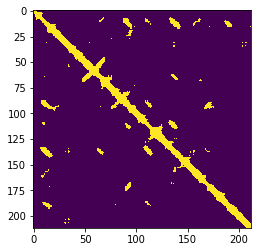

In [75]:
plt.imshow(reshaped > 0.5)
plt.show()

In [30]:
# reshaped
id1 = 'TR280'
print (np.count_nonzero (c_maps[id1]))
print(c_maps[id1].shape[0] * c_maps[id1].shape[1])

1000
9216


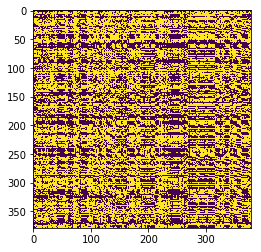

In [9]:
plt.imshow(c_map_pred[:, :, 0] - c_map_pred[:, :, 1] > 0.5)
plt.show()

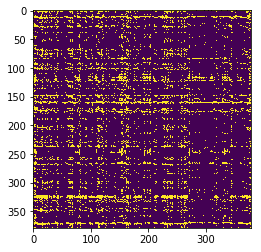

In [17]:
# np.argmax(c_map_pred, axis=-1)
# plt.imshow (c_map_pred[:, :, 0] > c_map_pred[:, :, 1])
# plt.imshow(np.argmax(c_map_pred, axis=-1))
plt.show()

In [37]:
c_map_pred[:, :, 0].shape

(379, 379)

In [23]:
np.count_nonzero (c_map_pred[:, :, 1] > 0.5)

68138

In [132]:
"""
CONFOLD server requires:
E-mail Address
Job Id
Sequence
Secondary Structure
Contacts
"""
import pandas as pd


def contacts_in_RR_format(
        pdb_id,
        contact_map,
        sequence,
        sec_structure,
        threshold=8):
    """
    Convert the contact map matrix into the RR format.
    (Note that this is currently unordered)

    Format is:

    i  j  d1  d2  p

    i, j are the indices of the residues in contact.
    i < j (since the matrix is symmetrical)

    d1 and d2 indicates the threshold for contact.
    d1 = 0, d2 = 8 Angstrom is the norm.

    p indicates the probability of the two residues 
    in contact. (0.0-1.0)
    Contacts should be listed in decreasing order

    Any pair not listed is considered to not be in contact

    See here for more information:
    http://predictioncenter.org/casp13/index.cgi?page=format

    :param pdb_id: pdb id
    :type  pdb_id: str
    :param contact_map: contact matrix
    :type  contact_map: numpy array
    :param sequence: one letter aa sequence
    :type  sequence: str 
    :param sec_structure: one letter secondary structure
    :type  sec_structure: str
    :param threshold: threshold of contact
    :param threshold: int
    :returns: a string in the correct format
    :rtype:   str
    """

    df = pd.DataFrame(contact_map)

    columns = df.columns

    contacts = {}
    for index, row in df.iterrows():
        for col_num, col in enumerate(columns):
            prob = row[col]
            if prob > 0.5:
                min1 = min(index, col_num)
                max1 = max(index, col_num)
                contacts[str(min1) + ' ' + str(max1)] = prob  # int (prob)
#                 contacts.append((index, col_num, prob))

#     contact_str = "Sequence: \n%s\n\n\n" % sequence
#     contact_str += "Secondary Structure: \n%s\n\n\n" % sec_structure
#     contact_str += "Residues in Contact:\n"

    contact_str = ""
    for resids, prob in contacts.items():
        contact_str += resids + " 0 " + str(threshold) + " " + str(prob) + '\n'
#     return contacts

    return contact_str


# x = contacts_in_RR_format(
#     "PDBID",
#     c_map_pred.reshape(,),
#     "AAAA",
#     ""
# )

def write_out_all_predictions(one_hot_aa, cmaps, path='coordinate_prediction/', maxlen=500):
    """
    Write out the information for all the inputs
    required for PDB file reconstruction.

    Since Confold server only takes in proteins of maximum length 500,
    we will impose a cap.

    :param one_hot_aa:
    :type  one_hot_aa: numpy array
    :param cmaps:
    :type  cmaps: numpy array
    :param path: path to write out
    :type  path: str
    :param 
    """

    from math import sqrt

    for pdb_id, cmap in cmaps.items():
        #         print(pdb_id)
        one_hot_seq = one_hot_aa[pdb_id]
#         length = int((cmap.shape[0]))
        length = one_hot_aa[pdb_id].shape[0]

        aa_seq = "".join(
            list(fthe.aa_enc.inverse_transform(one_hot_seq).reshape(-1)))
        cmap = cmap.reshape((length, length))
        out = contacts_in_RR_format(
            pdb_id,
            cmap,
            sequence=aa_seq,
            sec_structure="",
        )

        print(length)
        if length < maxlen:
            out_file = open(path + pdb_id + '.txt', "w+")
            out_file.write(out)
            out_file.close()
        else:
            print(pdb_id)


# write_out_all_predictions(
#     fasta_seqs,
#     c_maps)

In [119]:
True > 0.5

True

In [79]:
int(False)

0

In [63]:
# c_map_pred.shape#.reshape()#.shape
c_maps['TR217'].shape

(210, 210)

In [46]:
print (x)

Sequence: 
AAAA


Secondary Structure: 
BBBB


Residues in Contact:
0 0 10.917419
0 1 9.447587
0 2 5.150753
0 3 1.4173317
0 4 2.670597
1 1 8.65955
1 2 5.712083
1 3 8.800732
1 4 9.907942
2 2 8.1895685
2 3 1.4162312
2 4 9.609776
3 3 3.6729276
3 4 8.167943
4 4 1.8101193



In [24]:
import pandas as pd

# pd.DataFrame(c_map_pred[:, :, 1])
min(3,4)

3

In [83]:
len("MSVKRRTFLQGAAGAIGLAMAQGALSKIVYAQGAAGTLRVAIAKPAGNLDPQSHYAIWAIQDLMFEPLVKYGKGGQIEPCLATDWKIEDGGKTLHLTLREGVKFQDGTKFDAAACKWNLERWMGIDQFSWMNCSKHFQSLEVVDDYHITVHFKEPVLALMQELSYTRPTRFLSPKSVDADGKFKEPVGTGPWVQISADDTQSVFEHYDGYWGDKPTYERLEAKVIPDARSRVAALRAGEIDLVGGFWIAPLTPEEGKQLEAAGFNVVVDPGNVTLVMAFNPDRAEPLKDPQVRKAVSIGIDRAAISKVLYHGYAKPAGNMFSAALPYAGKQFDAPVRDAAAASALLEKAGWTGSPIRSKDGKPLTLELVVSPDAVPGSRVIAEVIQSEMKEVGIDLVIRSVDHASKHTDMLEQKYDLGFFLTYGAPYDPFGSLVALCLSTFKNDVEGKLVTDPVNLDPLINAATAATGDQIEPTIQKVYDWLRDNDAIAPLVYVPSIWAHSKRVQGFTSPVTEYDMPYENIVLAE")

525

In [28]:
a = np.symmetric((3,3))

AttributeError: module 'numpy' has no attribute 'symmetric'

In [51]:
 "".join(list (fthe.aa_enc.inverse_transform(fasta_seqs['T0759']).reshape(-1)))

'MGHHHHHHSHMVVIHPDPGRELSPEEAHRAGLIDWNMFVKLRSQECDWEEISVKGPNGESSVIHDRKSGKKFSIEEALQSGRLTPAHYDRYVNKDMSIQELAVLVSGQK'

In [87]:
len("MSVKRRTFLQGAAGAIGLAMAQGALSKIVYAQGAAGTLRVAIAKPAGNLDPQSHYAIWAIQDLMFEPLVKYGKGGQIEPCLATDWKIEDGGKTLHLTLREGVKFQDGTKFDAAACKWNLERWMGIDQFSWMNCSKHFQSLEVVDDYHITVHFKEPVLALMQELSYTRPTRFLSPKSVDADGKFKEPVGTGPWVQISADDTQSVFEHYDGYWGDKPTYERLEAKVIPDARSRVAALRAGEIDLVGGFWIAPLTPEEGKQLEAAGFNVVVDPGNVTLVMAFNPDRAEPLKDPQVRKAVSIGIDRAAISKVLYHGYAKPAGNMFSAALPYAGKQFDAPVRDAAAASALLEKAGWTGSPIRSKDGKPLTLELVVSPDAVPGSRVIAEVIQSEMKEVGIDLVIRSVDHASKHTDMLEQKYDLGFFLTYGAPYDPFGSLVALCLSTFKNDVEGKLVTDPVNLDPLINAATAATGDQIEPTIQKVYDWLRDNDAIAPLVYVPSIWAHSKRVQGFTSPVTEYDMPYENIVLAE")

525

In [124]:
pdb_id = "TR772"
one_hot = fasta_seqs[pdb_id]
one_hot = one_hot.reshape((1,) + one_hot.shape)
# cmap = cmap.reshape((length, length))
length = one_hot.shape[1]
prediction = model.predict(one_hot)
prediction = prediction.reshape((length, length))

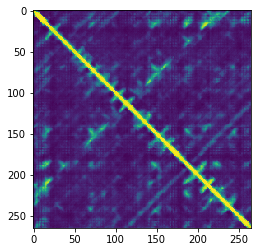

In [125]:
plt.imshow(prediction)
plt.show()

In [133]:
# print(pdb_id_out)
pdb_id_out = contacts_in_RR_format(
    pdb_id,
    prediction,
    "",
    "",
    threshold=8)



In [134]:
path = 'coordinate_prediction/'
out_file = open(path + pdb_id + '.txt', "w+")
out_file.write(pdb_id_out)
out_file.close()

In [127]:
print (pdb_id_out)

Sequence: 



Secondary Structure: 



Residues in Contact:
0 0 0 8 0.96044123
0 1 0 8 0.94619256
0 2 0 8 0.9661654
0 3 0 8 0.59477407
0 4 0 8 0.6414608
0 236 0 8 0.5057766
1 1 0 8 0.92709064
1 2 0 8 0.9420152
1 3 0 8 0.9466001
1 4 0 8 0.6788205
1 5 0 8 0.6485825
1 236 0 8 0.6218704
2 2 0 8 0.9724659
2 3 0 8 0.9708322
2 4 0 8 0.98539764
2 5 0 8 0.77254474
2 6 0 8 0.7770721
2 235 0 8 0.54968894
2 236 0 8 0.50558275
3 3 0 8 0.9779646
3 4 0 8 0.98630214
3 5 0 8 0.98904634
3 6 0 8 0.85564053
3 7 0 8 0.875448
3 215 0 8 0.50465405
3 224 0 8 0.500265
3 225 0 8 0.50910276
3 226 0 8 0.5382236
3 234 0 8 0.60090554
3 235 0 8 0.5077351
4 4 0 8 0.9928146
4 5 0 8 0.9960809
4 6 0 8 0.996384
4 7 0 8 0.8912404
4 8 0 8 0.9282948
4 215 0 8 0.5542204
4 222 0 8 0.6171688
4 223 0 8 0.6014122
4 224 0 8 0.623182
4 225 0 8 0.66347474
4 226 0 8 0.6396231
4 230 0 8 0.5971591
4 232 0 8 0.6498829
4 233 0 8 0.6412593
4 234 0 8 0.6496347
5 5 0 8 0.9978684
5 6 0 8 0.9983685
5 7 0 8 0.99790657
5 8 0 8 0.9442078
5 9 0 